##### Data Preprocessing
In this step, we'll perform various data preprocessing tasks such as removing duplicates, handling missing values, encoding categorical variables, etc.

##### Data Visualization
We will chart to visualize the dataset and identify patterns in the data.

##### Feature Selection
We will use PCA for dimension reductionality

##### Split the Data into Training and Testing sets
We will use train_test_split function to split the dataset into training and testing sets.

##### Model Selection and Training
We will select a machine learning algorithm and train the model using the training dataset.

##### Model Evaluation
In this step, we will evaluate the performance of the trained model using various evaluation metrics such as accuracy, precision, recall, F1 score, etc.

##### Model Tuning
If the model performance is not satisfactory, we can tune the model's hyperparameters using  Grid Search.

##### Final Model Selection and Deployment
After tuning the model, we can use the test sets to deploy the model.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pd.set_option('display.max_columns', None)

## Global Variables

In [31]:
TRAIN_DF = 'aps_failure_training_set.csv'
TEST_DF = 'aps_failure_test_set.csv'

model_list  = []
metric_list = []    
score_list  = []

## Functions

In [3]:
def reading_dataset_into_df(data):
    '''Reads the dataset into pandas dataframe.
    '''
    
    df = pd.read_csv(data, low_memory=False)
    
    print(df.shape)
    # print(df.info(verbose=True, show_counts=True))
    
    return df

In [4]:
def check_missing_values_and_drop_col(data):
    '''
    Checks for the percentage of missing values and drops the column if its missing value is >50%
    '''
    replace_na = data.replace('na', np.nan)
    calc_na = replace_na.isnull().mean() * 100
    col_name_to_drop = calc_na[calc_na >= 50].index.tolist()
    # print(col_name_to_drop)
    
    df_to_drop_mv = replace_na.copy()
    for cols in col_name_to_drop:
        df_to_drop_mv = df_to_drop_mv.drop(cols, axis=1) 
    # print(df_to_drop_mv.shape)
    
    return df_to_drop_mv

In [5]:
def fill_with_median_left_skewed_data(data):
    '''From the data preprocessing, we encountered that most of the columns are left skewed 
       which means we need to fillna it with median instead of mean
    '''
    
    skewness = data.skew(axis = 0, skipna = True).values
    cols = data.skew(axis = 0, skipna = True).index
    
    skew_data = pd.DataFrame({'Skewness':skewness}, index = cols)
    
    skew_data['Distribution'] = np.nan
    skew_data['Distribution'] = skew_data.apply(lambda x: 'Left Skewed' if x['Skewness']>0.5 else x['Distribution'], axis=1)
    skew_data['Distribution'] = skew_data.apply(lambda x: 'Right Skewed' if x['Skewness']<-0.5 else x['Distribution'], axis=1)
    skew_data['Distribution'] = skew_data.apply(lambda x: 'Normal Distribution' if (x['Skewness']<=0.5 and x['Skewness']>=-0.5)  else x['Distribution'], axis=1)
    print(skew_data.Distribution.value_counts())
    
    return skew_data

In [6]:
def fillna_with_median(data):
    '''Replace NAN's with median 
    '''

    data['class'] = data['class'].replace('neg',0).replace('pos',1)
    datatype_conversion = data.astype(float)
    
    fill_missing_values = datatype_conversion.fillna(datatype_conversion.median(), inplace=False)
       
    check_isna_sum = fill_missing_values.isna().sum()
    if check_isna_sum.sum() == 0:
        print("All missing values have been filled")
    else:
        print(f"Number of missing values remaining: {check_isna_sum.sum()}")
    
    return fill_missing_values


In [7]:
def drop_duplicates(data):
    '''Drop duplicated rows from the dataset
    '''
    
    data = data.drop_duplicates()
    
    return data

In [8]:
def train_test_data_split(data):
    '''Splitting training and testing data into separate variable based on the target variable
    '''
    
    X = data.drop('class',axis=1)
    y = data['class']
    
    return X,y

In [9]:
def categorize_columns_without_target_variable(X):
    '''
    Split the data into three array blocks as continuous, discrete, and object data types.
    '''
    
    float_cols = []
    object_cols = []
    int_cols = []
    
    for col in X.columns:
        try:
            X[col] = pd.to_numeric(X[col])
            if (X[col] % 1 > 0).any():
                # it is float
                float_cols.append(col)
            else:
                int_cols.append(col)
        except:
            object_cols.append(col)

    for col in float_cols:
        fig, ax = plt.subplots()
        fig.set_size_inches(15.5, 6.5)
        n_bins = 25
        max_range = 10000
        check_bin = max_range + n_bins
        check_bin2 = int(max_range/n_bins)
        ax.hist(X[col], bins=n_bins, range=(0, max_range), color='blue')
        ax.set_title(f'Distribution of {col}')
        ax.set_xticks(np.arange(0, check_bin, check_bin2))
        ax.set_ylabel("Frequency")
        ax.set_xlabel(col)
        # plt.show() Removes the plot
        
    return None

In [10]:
def splitting_train_and_test_sets(data):
    '''Splitting the dataset into train and test sets.
    '''
    
    features = data.drop(['class'], axis=1)
    target = data['class']

    # split dataset into train and dev set 90:10 %
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

    return features_train, features_test, target_train, target_test


In [11]:
def setting_threshold_classes(data):
    '''Decoding everything to binary numbers
    '''
    
    lb = Binarizer()
    lb.fit(target_train.values.reshape(-1, 1))
    target_train_bi = lb.transform(target_train.values.reshape(-1, 1))
    target_test_bi = lb.transform(target_test.values.reshape(-1, 1))
    
    return target_train_bi, target_test_bi

In [12]:
def pca_transformation(feat_train, feat_test):
    '''Normalizes the data and dimension reductionality is done using 
       principal component analysis.
    '''
    
    # normalize using standard method
    scaler = StandardScaler()
    scaler.fit(features_train)
    normalized_train = scaler.transform(features_train)
    normalized_test = scaler.transform(features_test)

    # select principle components by PCA
    pca = PCA(n_components=60)
    pca.fit(normalized_train)
    pca_train = pca.transform(normalized_train)
    pca_test = pca.transform(normalized_test)
    
    return pca_train, pca_test
    

In [13]:
def pca_new_train_test_set(pca_training, pca_testing):
    '''Stores the output from pca_transformation into new train and test data
    '''
    
    X_train = pca_train
    X_test = pca_test
    y_train = target_train_bi.reshape(-1,1)
    y_test = target_test_bi.reshape(-1,1)
    
    return X_train, X_test, y_train, y_test

In [14]:
# def test_predict(model, X_train, X_test, y_train, y_test):
#     '''Generates the Naive Bayes model and Creates a classficiation report based on the performance metrics
#     '''
#     model.fit(X_train, y_train.ravel())
#     prediction_test = model.predict(X_test)
   
#     # create list of metric to be examined
#     metric_functions = [accuracy_score, precision_score, recall_score,f1_score,roc_auc_score]
#     metric_functions_text = ['accuracy_score', 'precision_score', 'recall_score','f1_score','roc_auc_score']
    
#     # for loop of each of the 5 metrics
#     for metric_function, metric_function_text in zip(metric_functions, metric_functions_text):
#         model_text_list.append(model); metric_list.append(metric_function_text); score_list.append(metric_function(y_test, prediction_test))
    
#     data = {'model':model_text_list, 'metric': metric_list, 'test predict score (20% data)': score_list}
#     result = pd.DataFrame(data=data)
    
#     return result

In [34]:
def test_predict_grid(models, param_grids, X_train, X_test, y_train, y_test):
    '''Generates multiple models with grid search and creates a classification report based on the performance metrics
       Args:
        - models (list): list of tuples containing model name and model object
        - param_grids (list): list of dictionaries containing the grid parameters for each model
    '''
    
    for i, (model_name, model_obj) in enumerate(models):
        grid_search = GridSearchCV(model_obj, param_grid=param_grids[i], cv=5, n_jobs=-1)    
        grid_search.fit(X_train, y_train.ravel())
        best_model = grid_search.best_estimator_
        prediction_test = best_model.predict(X_test)

        metric_functions = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
        metric_functions_text = ['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score']

        for metric_function, metric_function_text in zip(metric_functions, metric_functions_text):
            model_list.append(model_name)
            metric_list.append(metric_function_text)
            score_list.append(metric_function(y_test, prediction_test))

        means = grid_search.cv_results_['mean_test_score']
        stds = grid_search.cv_results_['std_test_score']
        params = grid_search.cv_results_['params']
        # for mean, std, param in zip(means, stds, params):
        #     print(f"Model: {model_name}, Accuracy: {mean:.3f} (+/-{std * 2:.03f}), Params: {param}")

    data = {'Model': model_list, 'Metric': metric_list, 'Prediction': score_list}
    result_df = pd.DataFrame(data=data)
    
    return result_df


## Main Script

In [16]:
#READING THE TRAINING DATA
train_df = reading_dataset_into_df(TRAIN_DF)

(60000, 171)


In [17]:
#READING THE TESTING DATA
test_df = reading_dataset_into_df(TEST_DF)

(16000, 171)


In [18]:
#DROPPING COLS WITH NA PERCENTAGE GREATER THAN 50%
train_df = check_missing_values_and_drop_col(train_df)
test_df = check_missing_values_and_drop_col(test_df)

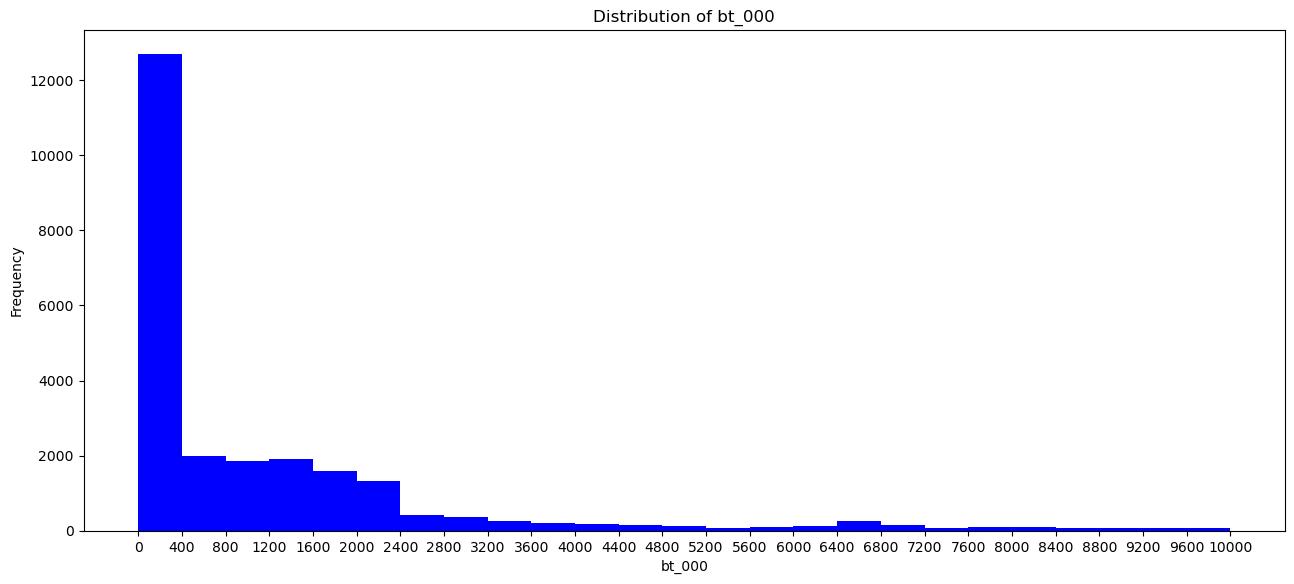

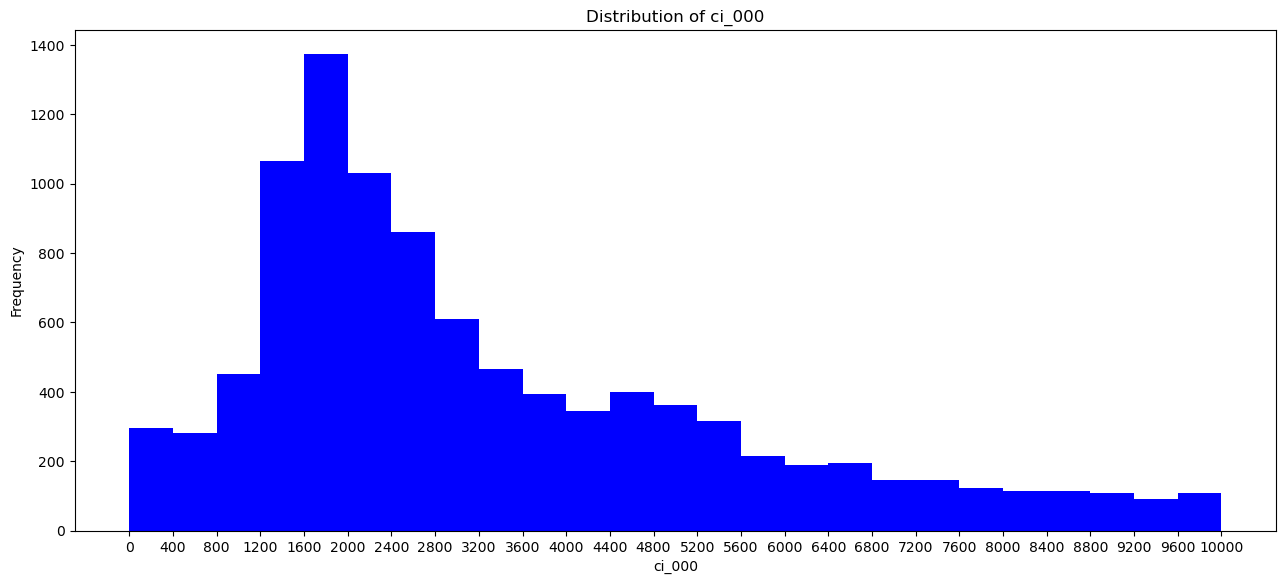

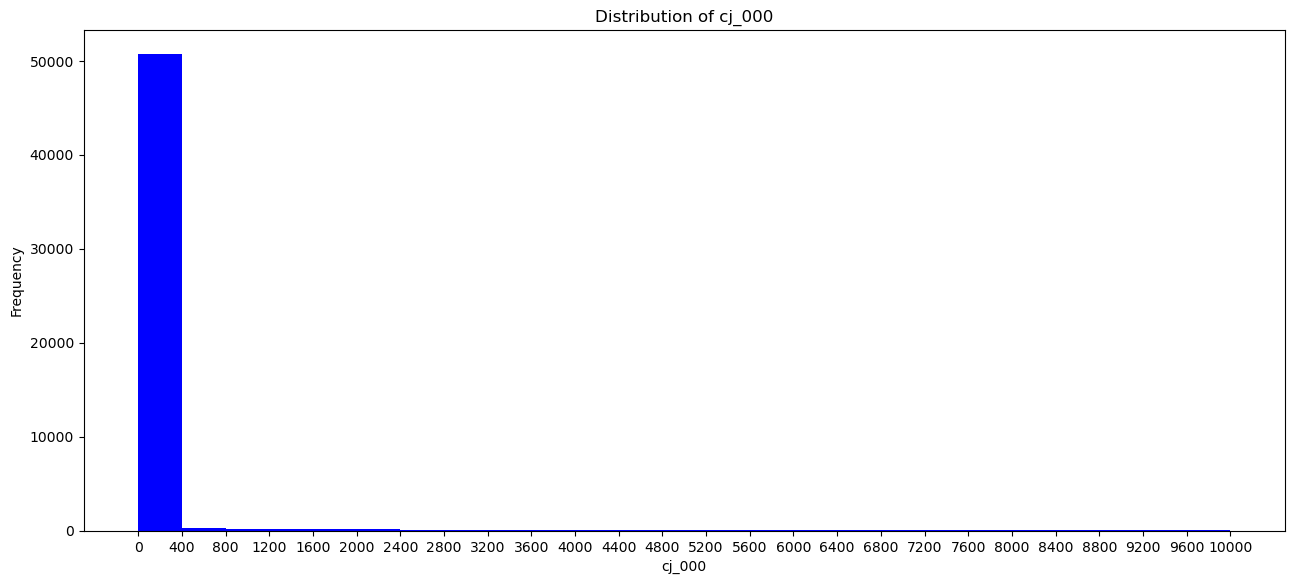

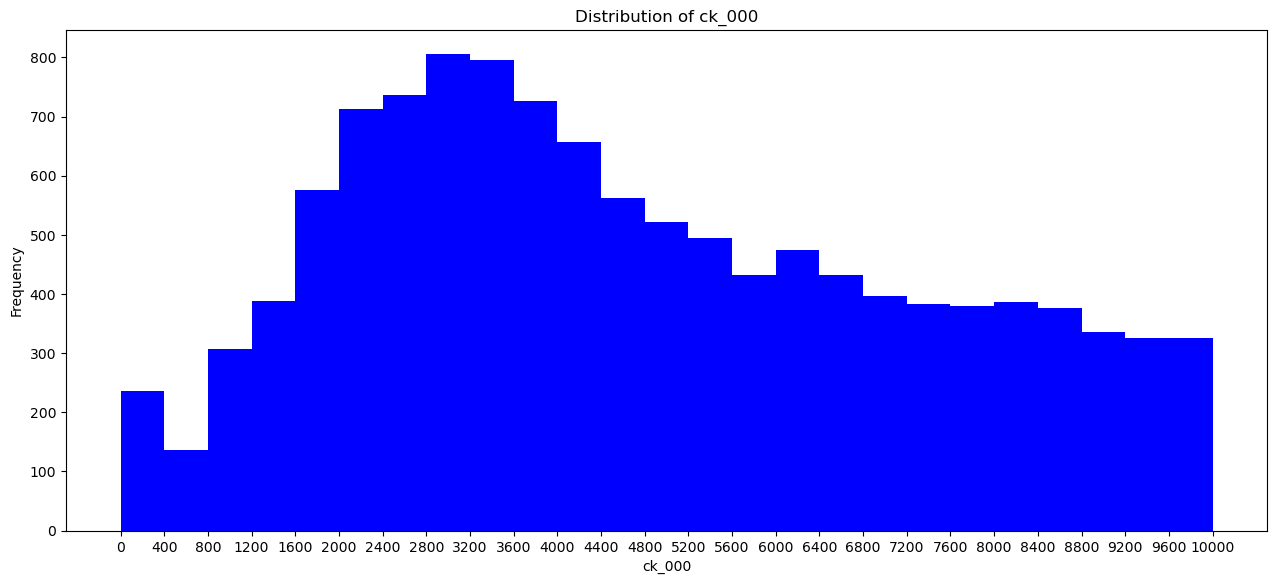

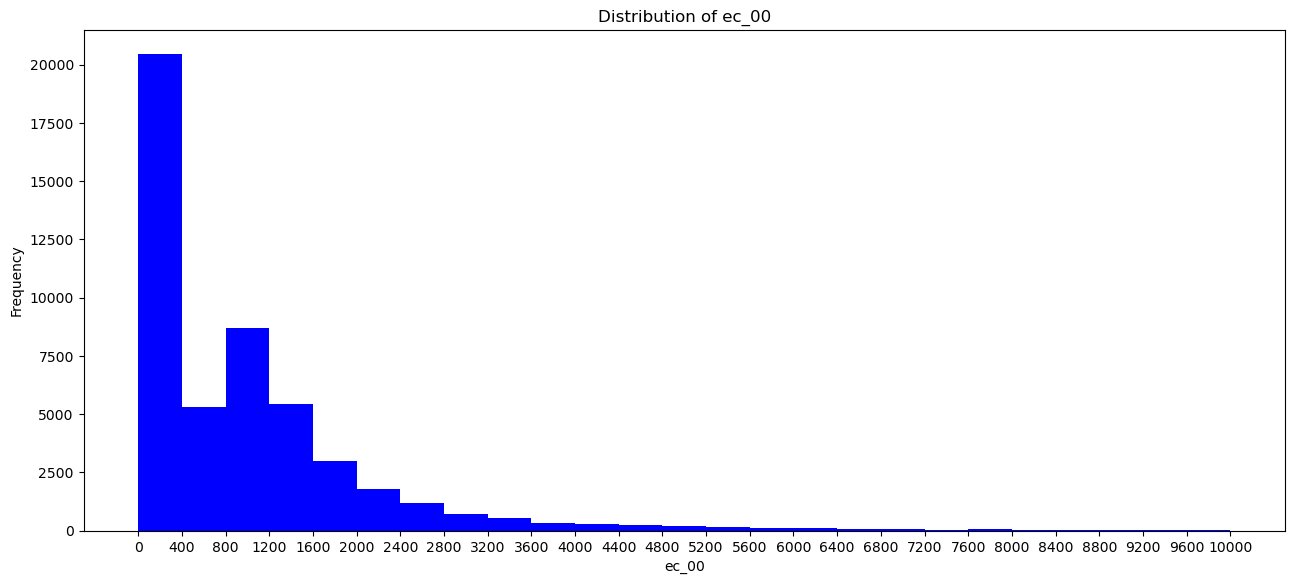

In [19]:
variable_type = categorize_columns_without_target_variable(train_df)

In [20]:
#FILL NAN VALUES WITH MEAN 
train_df = fillna_with_median(train_df)
# test_df = fillna_with_median(test_df)

All missing values have been filled


In [21]:
train_df = drop_duplicates(train_df)
# test_df = drop_duplicates(test_df)

In [22]:
print(train_df['class'].value_counts())
# print(test_df['class'].value_counts())

0.0    58999
1.0     1000
Name: class, dtype: int64


In [26]:
#SPLITTING THE DATASET INTO TEST AND TRAIN SETS
features_train, features_test, target_train, target_test = splitting_train_and_test_sets(train_df)

In [27]:
#CONVERTING THE CLASS TO BINARY
target_train_bi, target_test_bi = setting_threshold_classes(target_train)

In [28]:
#NORMALIZES AND SCALES THE DATA FOR PCA
pca_train, pca_test = pca_transformation(features_train, features_test)

In [29]:
#SPLITTING THE NEW DATASET AFTER DIMENSION REDUCTIONALITY
X_train, X_test, y_train, y_test = pca_new_train_test_set(pca_train, pca_test)

In [36]:
# HYPERPARAMATER TUNING FOR ML MODELS
models = [('Random Forest', RandomForestClassifier()),          
          ('Logistic Regression', LogisticRegression()), 
          ('Naive Bayes', GaussianNB())]

param_grids = [{'n_estimators': [10, 50, 100],
                'max_depth': [None, 5, 10]},
               {'penalty': ['l2'],
                'C': [0.1, 1.0, 10.0]},
               {}]
result_df = test_predict_grid(models, param_grids, X_train, X_test, y_train, y_test)


C:\Users\peri_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
result_df

,Model,Metric,Prediction
0,Random Forest,accuracy_score,0.990417
1,Random Forest,precision_score,0.848276
2,Random Forest,recall_score,0.569444
3,Random Forest,f1_score,0.681440
4,Random Forest,roc_auc_score,0.783789
5,Logistic Regression,accuracy_score,0.988500
6,Logistic Regression,precision_score,0.767123
7,Logistic Regression,recall_score,0.518519
8,Logistic Regression,f1_score,0.618785
9,Logistic Regression,roc_auc_score,0.757817


In [54]:
max_index = result_df.loc[result_df['Prediction'] == result_df['Prediction'].max()]
best_model = max_index.Model.tolist()[0]

'Random Forest'

To be continued ....